## Methods:

(click on the links below to get to the corresponding cells)

This notebook experiments with different types of adversarial attacks. If you are looking for a command line script see the `main.py`

## 1. [Iterative_Fast_Gradient_Sign_Targeted_Attack](#Iterative_Fast_Gradient_Sign_Targeted_Attack)
- Assumes access to model's gradients. This is the default method in `main.py` for now..


## 2. [Black_Box_Zeroth_Order_Optimization](#Black_Box_Zeroth_Order_Optimization)
- Does **not** assume access to model gradients. Try to approximate them using 2 inputs with noise added

## 3. Natural Evolution Strategies (Black Box)
- NOT IMPLEMENTED YET
- Does **not** assume access to model gradients. Sample a family of perturbations from a distribution (e.g. Gaussian) to try to approximate the gradient

## 4. [Modifying_foreground_or_background_only](#Modifying_foreground_or_background_only)


## 5. [Modifying_Specific_Superpixels](#Modifying_Specific_Superpixels)


## 6. [Next_Steps](#Next_Steps)

In [1]:
import os
import random
import numpy as np
from PIL import Image
from typing import Union
import matplotlib.pyplot as plt

import tensorflow as tf

C:\Users\SiFuBrO\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\SiFuBrO\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\SiFuBrO\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Set global variables

In [2]:
SEED = 1234   # to ensure reproducability
IMG_SIZE = (224, 224)

### Set random seeds for reproducability

In [3]:
os.environ["PYTHONHASHSEED"]= str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Download pretrained model on imagenet

In [4]:
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SIZE + (3,), 
                                              include_top = True, 
                                              weights = 'imagenet')

In [5]:
#base_model.summary()

### Freeze model because we do not want to optimize its weights - only the input image

In [6]:
base_model.trainable = False

### Helper functions to preprocess input image for the model and the output

In [7]:
def preprocess(image: Union[tf.Tensor, np.ndarray]) -> tf.Tensor:
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    # form batch dimension
    image = tf.expand_dims(image,0) 
    return image

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

def get_imagenet_labels(probs, topk=1):
    return decode_predictions(probs, top=topk)[0][0]

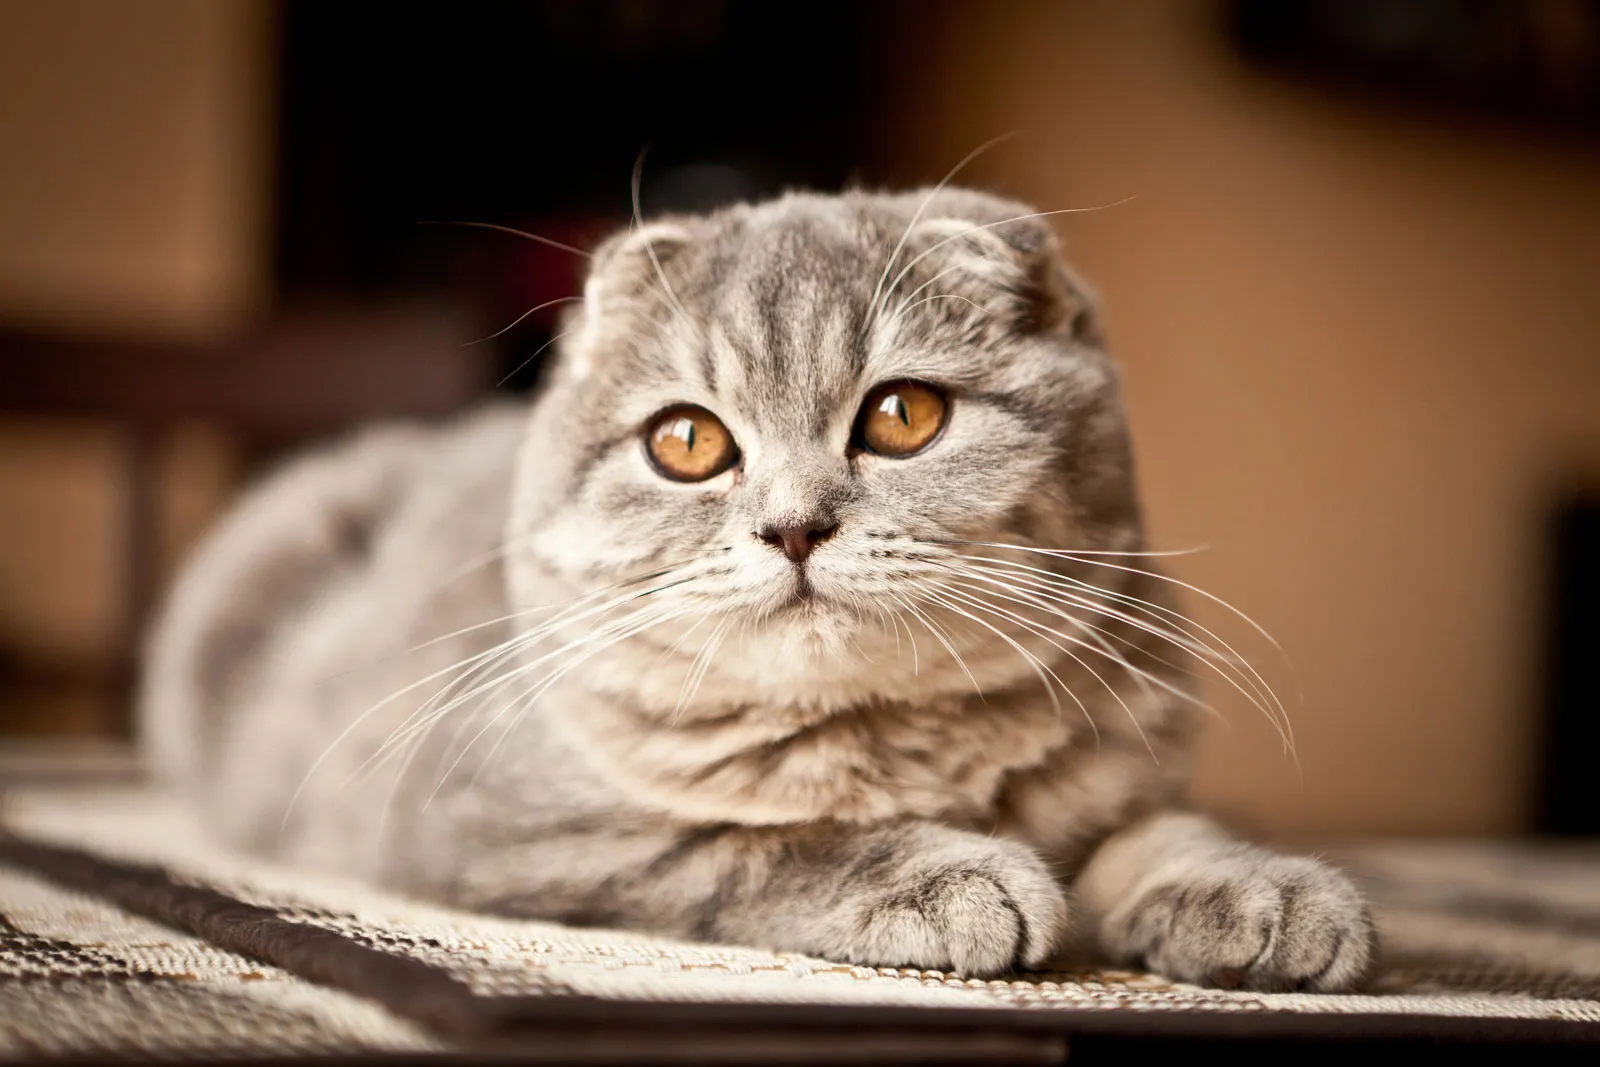

In [8]:
input_pil_image = Image.open("./cat.jpg")
input_pil_image

### Function to get model predictions

In [9]:
def get_model_pred(image, preproc=True):
    if preproc:
        image = preprocess(image)
    preds = base_model.predict(image)
    img_id, label, prob= get_imagenet_labels(preds)
    return label, prob, preds

In [10]:
image_array = np.array(input_pil_image)[:,:,:3]
orig_label, orig_prob, orig_preds = get_model_pred(image_array)
orig_label, orig_prob

1/1 [==============================] - 1s 837ms/step


('Egyptian_cat', 0.2698532)

In [11]:
# index of Egyptian cat
np.argmax(orig_preds)

285

## Index of "pug" (type of dog) is 254 and index of "Egyptian_cat" is 285

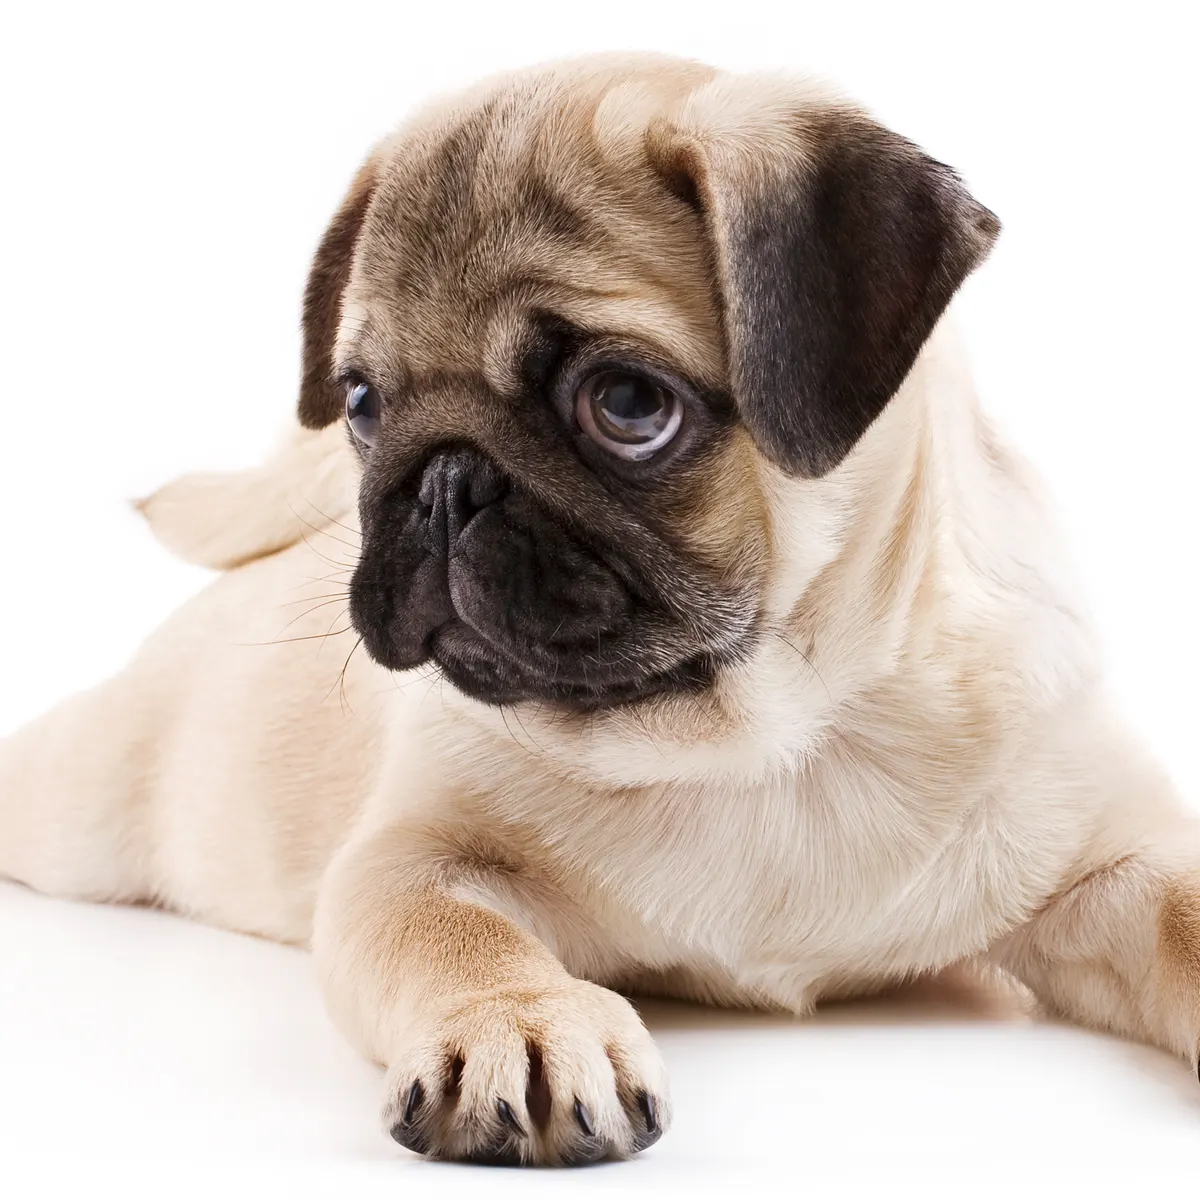

In [12]:
dog = Image.open("./pug_dog.jpg")
dog

In [13]:
image_array = np.array(dog)[:,:,:3]
target_label, prob, preds = get_model_pred(image_array)
target_label, prob

1/1 [==============================] - 0s 92ms/step


('pug', 0.9053926)

In [14]:
# index of pug dog
np.argmax(preds)

254

<a id='Iterative_Fast_Gradient_Sign_Targeted_Attack'></a>
# `1. Iterative Fast Gradient Sign Targeted Attack`


- Goal is add perturbation to "cat" so it is predicted as a "pug"


### `Remark`: Assumes we have access to the model and it's gradient. Otherwise we can use black-box attacks like zeroth-order optimization or natural evolution strategies

### Get 1-hot target label

In [15]:
target_index = 254  #pug
y_target = tf.one_hot(target_index, preds.shape[-1])
y_target = tf.reshape(y_target, (1, preds.shape[-1]))
y_target.shape #

TensorShape([1, 1000])

In [16]:
np.argmax(y_target)

254

In [17]:
_ , target_label, _ = get_imagenet_labels(y_target.numpy())
target_label

'pug'

In [18]:
type(base_model)

keras.src.engine.functional.Functional

In [19]:
def run_fast_gradient_sign_iterative_method(input_image,
                                        target_index, 
                                        model,
                                        loss_object, 
                                        learning_rate=0.05,
                                        sign_grad=True,
                                        adv_iterations = 30):
    '''
    - input_image: tf.Tensor of shape (batch, height, width, channels)
    - target_index: Integer in [0,999] representing the y_target (we want to fool the model in predicting y_target)
    - model: pretrained tensorflow model
    - learning_rate: float for Gradient Descent
    - sign_grad: Boolent. 
        + True if we use the sign of the gradient for optimization. 
        + False if we use the gradient itself
    - adv_iterations: Integer. How can interations of FSGM to perform
    '''
    # create a copy of the input
    x_adv = input_image
    
    print(f"y_target_index = {target_index}")
    y_target = tf.one_hot(target_index, preds.shape[-1])
    y_target = tf.reshape(y_target, (1, preds.shape[-1]))
    
    
    for iteration in range(adv_iterations):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            prediction = model(x_adv) #(1, 1000)
            loss = loss_object(y_target, prediction)
            
        print(f"Iteration {iteration} - pred  = {decode_predictions(prediction.numpy(), top=1)[0][0]}")
        print(f"Loss for y_target is {loss}")
        print("="*40)
        
    
        # If we managed to fool the model break the loop
        if np.argmax(prediction) == target_index:
            return x_adv

        # Calculate the gradient of the loss w.r.t image
        gradient = tape.gradient(loss, x_adv)

        if sign_grad:
            # get the sign of the gradient
            signed_grad = tf.sign(gradient)
            # Create the adversarial image --> move in the direction of gradient sign 
            x_adv = x_adv - learning_rate * signed_grad
        else:
            x_adv = x_adv - learning_rate * gradient
            
        x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)

        # if we didn't succeed just return the latest adversarial image..
        if iteration == adv_iterations-1:
            return x_adv

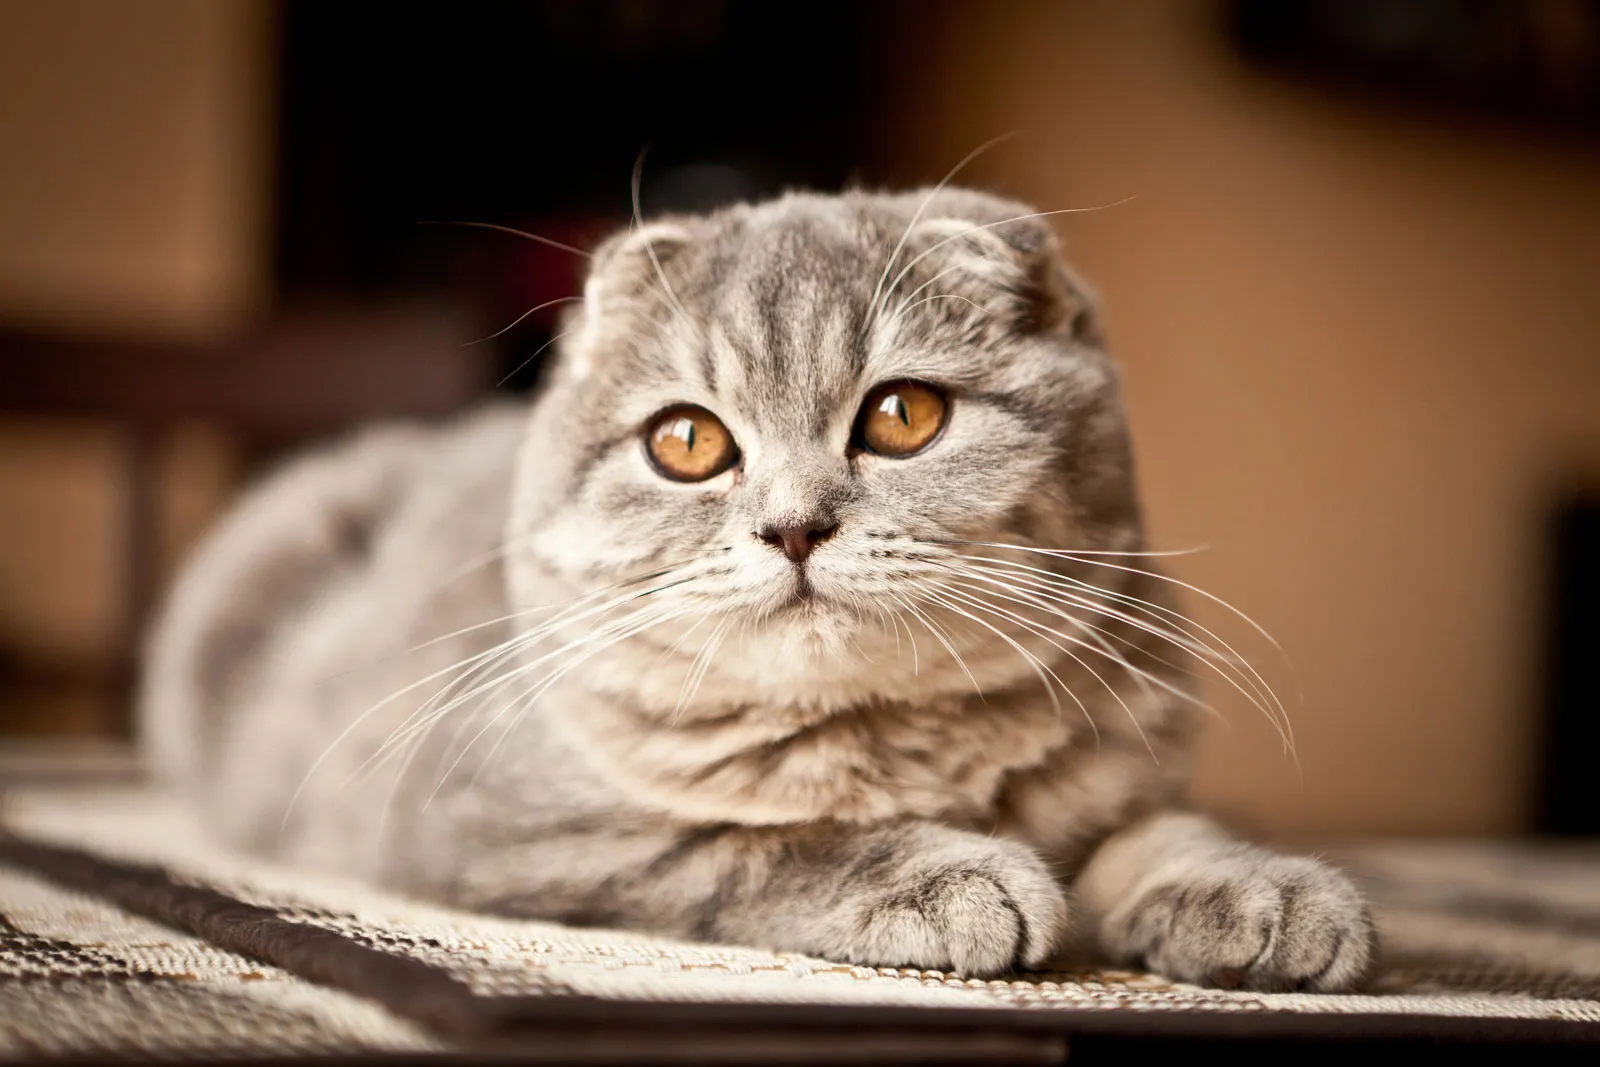

In [20]:
input_pil_image #cat

In [21]:
input_image = preprocess(input_pil_image)
input_image.shape, target_index

(TensorShape([1, 224, 224, 3]), 254)

## Try to maximize the log-likelihood (minimize entropy) of "pug" index

In [22]:
learning_rate = 0.01 #0.05
sign_grad = True
adv_iterations = 30

loss_object = tf.keras.losses.CategoricalCrossentropy()

In [23]:
x_adv = run_fast_gradient_sign_iterative_method(input_image,
                                    target_index, 
                                    base_model,
                                    loss_object, 
                                    learning_rate=learning_rate,
                                    sign_grad=sign_grad,
                                    adv_iterations = adv_iterations)

y_target_index = 254
Iteration 0 - pred  = ('n02124075', 'Egyptian_cat', 0.2698532)
Loss for y_target is 7.177538871765137
Iteration 1 - pred  = ('n02123394', 'Persian_cat', 0.2015177)
Loss for y_target is 3.3449630737304688
Iteration 2 - pred  = ('n02110958', 'pug', 0.40106183)
Loss for y_target is 0.9136396050453186


In [24]:
def postprocess(image: Union[tf.Tensor, np.ndarray]) -> Union[tf.Tensor, np.ndarray]:
    return image*127.5 + 127.5

In [25]:
def display_image(image):
    if type(image) == Image.Image:
        return image
    elif type(image) != np.ndarray:
        image = image.numpy()
    
    if type(image) == np.ndarray:
        return Image.fromarray(image.astype('uint8'), 'RGB')
    else:
        raise TypeError(f"Image is not of type ['PIL.Image', 'np.ndarray', 'tf.Tensor']. Received {image}")

## Display Result (adversarial image)

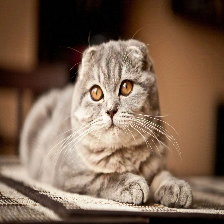

In [26]:
x_adv_array = postprocess(x_adv)[0].numpy()
display_image(x_adv_array)

## save original and adversarial image crop to disk

In [27]:
Image.fromarray(postprocess(input_image[0]).numpy().astype('uint8'), 'RGB').save("./results_fgsm/original_image_crop.png")
Image.fromarray(postprocess(x_adv)[0].numpy().astype('uint8'), 'RGB').save("./results_fgsm/adversarial_image_crop.png")

## Compare input image and adversarial

In [28]:
def display_difference(original_image, adversarial_image, labels=[]):
    original_image = postprocess(original_image[0]).numpy().astype(np.uint8)
    adversarial_image = postprocess(adversarial_image[0]).numpy().astype(np.uint8)
    
    noise_added = np.abs(original_image - adversarial_image).astype(np.float32)
    
    f, ax = plt.subplots(1,3, figsize=(12,8))
    ax[0].imshow(original_image)
    ax[0].set_title(f"orig_image,   pred={orig_label}")
    ax[1].imshow(adversarial_image)
    ax[1].set_title(f"adversarial_image,   pred={target_label}")
    ax[2].imshow(noise_added)
    ax[2].set_title("noise_added")

In [48]:
original_image = np.random.rand(224,224,3)
adversarial_image = np.random.rand(224,224,3)
noise_added = np.abs(original_image - adversarial_image).astype(np.float32)
noise_added.shape

(224, 224, 3)

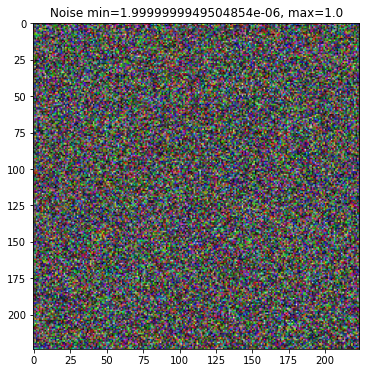

In [53]:
plt.figure(figsize=(6, 6))
plt.imshow(noise_added)
plt.title(f"Noise min={round(np.min(noise_added),2)}, max={round(np.max(noise_added),2)}")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


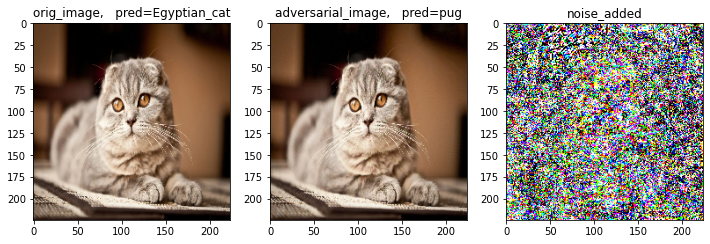

In [29]:
display_difference(input_image, x_adv, labels=[orig_label, ])

## Test image fooling the model

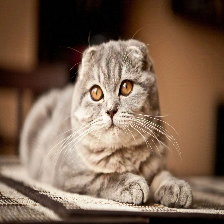

In [30]:
adv_pil = Image.open("./results_fgsm/adversarial_image_crop.png")
adv_pil

In [31]:
x_adv_array = np.array(adv_pil)
adv_label, adv_prob, adv_preds = get_model_pred(x_adv_array)
adv_label, adv_prob

1/1 [==============================] - 0s 71ms/step


('pug', 0.4017539)

## Original Image

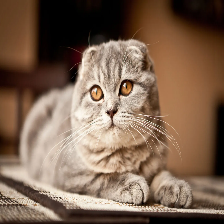

In [32]:
orig_pil = Image.open("./results_fgsm/original_image_crop.png")
orig_pil

In [33]:
orig_array = np.array(orig_pil)
orig_label, orig_prob, orig_preds = get_model_pred(orig_array)
orig_label, orig_prob

1/1 [==============================] - 0s 73ms/step


('Egyptian_cat', 0.26560003)

In [35]:
tf.__version__

'2.13.0'

## <a id='Black_Box_Zeroth_Order_Optimization'></a>
## 2. `Black Box Zeroth Order Optimization`

- Does not assume we have access to the gradients. We try to approximate them by querying the model on different inputs (with noise added)

In [37]:
def run_zero_order_optimization_method(input_image,
                                        target_index, 
                                        model,
                                        loss_object, 
                                        add_noise = True, 
                                        noise_max_val = 0.01,
                                        learning_rate=0.1,
                                        epsilon = 0.05,
                                        sign_grad=True,
                                        adv_iterations = 30):
    '''
    - input_image: tf.Tensor of shape (batch, height, width, channels)
    - target_index: Integer in [0,999] representing the y_target (we want to fool the model in predicting target_index)
    - model: pretrained tensorflow model
    - learning_rate: float for Gradient Descent
    - sign_grad: Boolean. 
        + True if we use the sign of the gradient for optimization. 
        + False if we use the gradient itself
    - adv_iterations: Integer. How can interations of FSGM to perform
    '''
    
    x_adv = input_image

    print(f"y_target_index = {target_index}")
    # 1-hot encoding - For categorical cross entropy
    # TODO: Change to Sparse Categorical Cross Entropy to simplify
    y_target = tf.one_hot(target_index, preds.shape[-1])
    y_target = tf.reshape(y_target, (1, preds.shape[-1]))
    
    
    for iteration in range(adv_iterations):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            
            if add_noise:
                noise = tf.random.uniform(x_adv.shape, minval = 0, maxval=noise_max_val, dtype=tf.float32, seed=SEED)
                x_adv +=  noise
            
            # get the model prediction
            prediction = model(x_adv)
        
            x_pos = tf.identity(x_adv)
            x_neg = tf.identity(x_adv)
            
            # use perturbation of x_adv to estimate gradient
            x_pos += epsilon
            x_neg -= epsilon
            
            if add_noise:
                # the average of uniform distribution is (max - min)/2 
                x_pos += noise_max_val/2.
                x_neg -= noise_max_val/2.
            
            
            # ensure value in correct range
            x_pos = tf.clip_by_value(x_pos, -1.0, 1.0)
            x_neg = tf.clip_by_value(x_neg, -1.0, 1.0)
            
            
            pred_pos = model(x_pos)
            pred_neg = model(x_neg)
            
            pos_loss = loss_object(y_target, pred_pos)
            neg_loss = loss_object(y_target, pred_neg)
            
            
            
        print(f"Iteration {iteration}")
        print(f"Pos Loss for y_target is {pos_loss}")
        print(f"Neg Loss for y_target is {neg_loss}")
        

        # Estimate the zeroth-gradient using the 2 samples created
        gradient = (pos_loss - neg_loss) / (2*epsilon)

        # Specify what gradient we will use
        if sign_grad:
            # get the sign of the gradient
            signed_grad = tf.sign(gradient)
            # Create the adversarial image --> move in the direction of gradient sign 
            x_adv = x_adv - learning_rate * signed_grad
        else:
            x_adv = x_adv - learning_rate * gradient
            
            
        # ensure correct values (as expected by the model)
        x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
        
        
        adv_label, adv_prob, adv_preds = get_model_pred(x_adv, preproc=False)
        print(f"Iteration {iteration} - pred  = {adv_label}-{adv_prob}")
        print("="*40)
        
        # If we managed to fool the model break the loop
        if np.argmax(prediction) == target_index:
            return x_adv
        
        # if we didn't succeed just return the latest adversarial image..
        if iteration == adv_iterations-1:
            return x_adv

In [38]:
def estimate_zeroth_order_gradient(model, loss, input_img, target_label, epsilon=0.01):
    # TODO: Create a class `AdversarialAttack` and subclass each method
    raise NotImplementedError()

In [39]:
input_image.shape, target_index

(TensorShape([1, 224, 224, 3]), 254)

In [40]:
x_adv = run_zero_order_optimization_method(input_image,
                                        target_index, 
                                        base_model,
                                        loss_object, 
                                        add_noise = True, 
                                        noise_max_val = 0.01,
                                        learning_rate=0.1, #0.05
                                        epsilon = 0.05, #0.01
                                        sign_grad=True,
                                        adv_iterations = 30)

y_target_index = 254
Iteration 0
Pos Loss for y_target is 7.263811111450195
Neg Loss for y_target is 7.167616844177246
1/1 [==============================] - 0s 95ms/step
Iteration 0 - pred  = Egyptian_cat-0.2556134760379791
Iteration 1
Pos Loss for y_target is 7.163951396942139
Neg Loss for y_target is 7.156370639801025
1/1 [==============================] - 0s 82ms/step
Iteration 1 - pred  = Egyptian_cat-0.2407718300819397
Iteration 2
Pos Loss for y_target is 7.194573402404785
Neg Loss for y_target is 7.049320220947266
1/1 [==============================] - 0s 116ms/step
Iteration 2 - pred  = Egyptian_cat-0.22312268614768982
Iteration 3
Pos Loss for y_target is 7.196836471557617
Neg Loss for y_target is 7.119968414306641
1/1 [==============================] - 0s 48ms/step
Iteration 3 - pred  = Egyptian_cat-0.24290984869003296
Iteration 4
Pos Loss for y_target is 7.144902229309082
Neg Loss for y_target is 7.154038429260254
1/1 [==============================] - 0s 89ms/step
Iteration 

## Display adversarial image

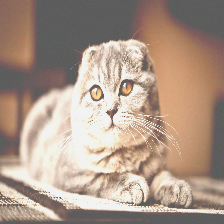

In [41]:
x_adv_postprocessed = postprocess(x_adv[0])
display_image(x_adv_postprocessed)

In [43]:
# image_array = np.array(input_pil_image)[:,:,:3]
adv_label, adv_prob, adv_preds = get_model_pred(x_adv, preproc=False)
adv_label, adv_prob

1/1 [==============================] - 0s 50ms/step


('tiger_cat', 0.21699108)

In [44]:
np.argmax(base_model(x_adv))

282

## Didn't fool the model...
## Experiment more!

In [45]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

In [46]:
import onnxruntime as ort

In [47]:
from rembg.bg import remove as rem_bg

C:\Users\SiFuBrO\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## `3. Natural Evolution Strategies`

## TODO

In [48]:
#!pip install rembg==2.0.57

In [49]:
from importlib import reload
import rembg

reload(rembg)

<module 'rembg' from 'C:\\Users\\SiFuBrO\\Anaconda3\\lib\\site-packages\\rembg\\__init__.py'>

In [50]:
rembg.__version__

'2.0.57'

<a id='Modifying_foreground_or_background_only'></a>
## 4. `Modifying foreground or background only`

### Download onnx u2net model from:
#### `https://github.com/danielgatis/rembg/releases/download/v0.0.0/u2net.onnx`
#### Added in `./u2net.onnx`

In [52]:
import onnxruntime as ort
from rembg.bg import remove as rem_bg
from rembg.sessions import u2net

In [54]:
# Load the u2net model with onnxruntime
u2net_session = ort.InferenceSession("./u2net.onnx")

In [56]:
# Create SessionOptions
options = ort.SessionOptions()
options.intra_op_num_threads = 2
options.inter_op_num_threads = 2
options.execution_mode = ort.ExecutionMode.ORT_PARALLEL
options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
options.enable_profiling = False
options.enable_mem_pattern = True
options.enable_cpu_mem_arena = True

In [57]:
def remove_background_and_get_mask(input_image):
    # set background color to black
    bgcolor = (0,0,0,255)
    
    # Create a new session for the u2net model
    session = u2net.U2netSession(model_name="u2net", sess_opts=options)
    
    # Perform the background removal
    result_image = rem_bg(input_image, session=session, bgcolor=bgcolor)
    
    # Get the mask
    masks = session.predict(input_image)
    mask = masks[0]
    
    # Convert the mask to a binary mask (0 for object, 1 for background)
    mask_np = np.array(mask)
    
    # mask background (only object will be "visible")
    # return 0 on the background and 1 ob the foreground object
    binary_mask_bg = np.where(mask_np > 5, 1, 0) 
    
    # mask foreground (only object will be "visible")
    # return 0 on the foreground and 1 ob the background object
    binary_mask_fg = np.where(mask_np > 5, 0, 1)
    
    return result_image, Image.fromarray(binary_mask_bg.astype(np.uint8)), Image.fromarray(binary_mask_fg.astype(np.uint8)) 

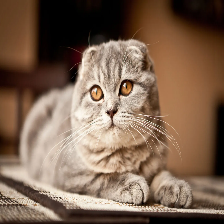

In [58]:
input_image_post = input_image[0].numpy() * 127.5 + 127.5
input_image_post = Image.fromarray(input_image_post.astype(np.uint8))
input_image_post

### Removing background of the image

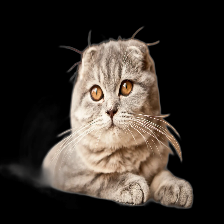

In [59]:
input_image_post_pil_no_bg, mask_bg, mask_fg = remove_background_and_get_mask(input_image_post)
input_image_post_pil_no_bg

### Visualizing the background and foreground masks

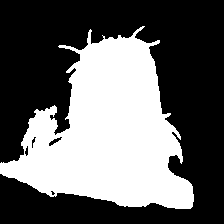

In [61]:
Image.fromarray(np.array(mask_bg).astype(np.uint8) * 255)

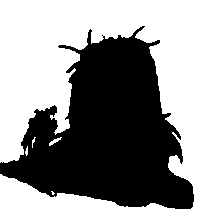

In [62]:
Image.fromarray(np.array(mask_fg).astype(np.uint8) * 255)

### Run adversarial perturbation only on the foreground (keep background fixed)

In [80]:
#@tf.py_function #(Tout=[tf.float32, tf.float32, tf.float32])
def combine_fg_adv_bg_original(input_image, x_adv):
    def py_func(input_image, x_adv):
        # postprocess
        input_image_post = input_image[0] * 127.5 + 127.5
        x_adv_post = np.array(x_adv[0]) * 127.5 + 127.5

        x_adv_pil = Image.fromarray(x_adv_post.astype(np.uint8))
        x_adv_pil_no_bg, mask_bg, mask_fg = remove_background_and_get_mask(x_adv_pil)

        x_adv_post = np.array(x_adv_pil_no_bg)[:,:,:3]

        # combine background or the original image with foreground of attack (x_adv)
        mask_bg_array = np.array(mask_bg)
        mask_bg_array = np.stack([mask_bg_array,mask_bg_array,mask_bg_array], -1)  #(224,224,3)

        mask_fg_array = np.array(mask_fg)
        mask_fg_array = np.stack([mask_fg_array,mask_fg_array,mask_fg_array], -1)  #(224,224,3)

        x_adv_post_masked_bg = x_adv_post * mask_bg_array
        x_adv_post_masked_fg = input_image_post * mask_fg_array

        x_adv_post_masked = x_adv_post_masked_bg + x_adv_post_masked_fg

        #batch it
        x_adv = tf.expand_dims(x_adv_post_masked, 0)
        x_adv = tf.clip_by_value(x_adv, 0., 255.)

        # from [0,255] -> to [-1,1] for the model
        x_adv = (x_adv - 127.5) / 127.5

        mask_bg_array = tf.cast(tf.convert_to_tensor(mask_bg_array), tf.float32)
        mask_fg_array = tf.cast(tf.convert_to_tensor(mask_fg_array), tf.float32)

        return x_adv, mask_bg_array, mask_fg_array

    return tf.py_function(py_func, [input_image, x_adv], [tf.float32, tf.float32, tf.float32])

In [81]:
def run_fgsm_masking_background(input_image,
                                        target_index, 
                                        model,
                                        loss_object, 
                                        epsilon = 0.05,
                                        learning_rate=0.05,
                                        sign_grad=True,
                                        adv_iterations = 50,
                                        mask_background=True):
    '''
    - input_image: tf.Tensor of shape (batch, height, width, channels)
    - target_index: Integer in [0,999] representing the y_target (we want to fool the model in predicting y_target)
    - model: pretrained tensorflow model
    - learning_rate: float for Gradient Descent
    - sign_grad: Boolent. 
        + True if we use the sign of the gradient for optimization. 
        + False if we use the gradient itself
    - adv_iterations: Integer. How can interations of FSGM to perform
    '''
    # create a copy of the input
    x_adv = tf.identity(input_image)
    
    print(f"y_target_index = {target_index}")
    y_target = tf.one_hot(target_index, preds.shape[-1])
    y_target = tf.reshape(y_target, (1, preds.shape[-1]))
    
    
    for iteration in range(adv_iterations):
        with tf.GradientTape() as tape:
            tape.watch(x_adv)
            #stop gradients
            input_image = tf.stop_gradient(input_image)
            
            x_adv, mask_bg, mask_fg = combine_fg_adv_bg_original(input_image, x_adv)
            
            mask_bg = tf.stop_gradient(mask_bg)
            mask_fg = tf.stop_gradient(mask_fg)
            
            
            prediction = model(x_adv) #(1, 1000)
            loss = loss_object(y_target, prediction)
            
        print(f"Iteration {iteration} - pred  = {decode_predictions(prediction.numpy(), top=1)[0][0]}")
        print(f"Loss for y_target is {loss}")
        print("="*40)
        
    
        # If we managed to fool the model break the loop
        if np.argmax(prediction) == target_index:
            return x_adv

        # Calculate the gradient of the loss w.r.t image
        gradient = tape.gradient(loss, x_adv)
        
        if mask_background:
            # mask gradient for the background
            gradient = gradient * mask_bg
        else:
            # mask gradient for the foreground
            gradient = gradient * mask_fg
        

        if sign_grad:
            # get the sign of the gradient
            signed_grad = tf.sign(gradient)
            # Create the adversarial image --> move in the direction of gradient sign 
            x_adv = x_adv - learning_rate * signed_grad
        else:
            x_adv = x_adv - learning_rate * gradient
            
        x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)

        # if we didn't succeed just return the latest adversarial image..
        if iteration == adv_iterations-1:
            return x_adv

In [82]:
x_adv = run_fgsm_masking_background(input_image,
                                        target_index, 
                                        base_model,
                                        loss_object, 
                                        epsilon = 0.05,
                                        learning_rate=0.05,
                                        sign_grad=True,
                                        adv_iterations = 50,
                                        mask_background=True)

y_target_index = 254
Iteration 0 - pred  = ('n02123394', 'Persian_cat', 0.3522523)
Loss for y_target is 6.578807830810547
Iteration 1 - pred  = ('n02123045', 'tabby', 0.1634951)
Loss for y_target is 4.068188190460205
Iteration 2 - pred  = ('n02110958', 'pug', 0.29891622)
Loss for y_target is 1.2075918912887573


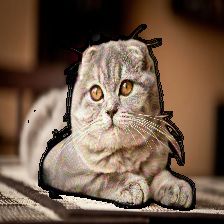

In [83]:
x_adv_postprocessed = postprocess(x_adv[0])
display_image(x_adv_postprocessed)

## TODO:
#### Need to improve the segmentation edges

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


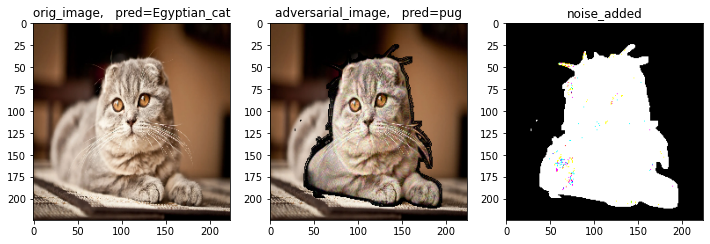

In [85]:
display_difference(input_image, x_adv)

## save original and adversarial image crop to disk

In [ ]:
Image.fromarray(postprocess(input_image[0]).numpy().astype('uint8'), 'RGB').save("./results_fgsm_mask_background/original_image_crop.png")
Image.fromarray(postprocess(x_adv)[0].numpy().astype('uint8'), 'RGB').save("./results_fgsm_mask_background/adversarial_image_crop.png")

## Test image fooling the model

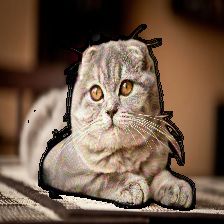

In [87]:
adv_pil = Image.open("./results_fgsm_mask_background/adversarial_image_crop.png")
adv_pil

In [88]:
x_adv_array = np.array(adv_pil)
adv_label, adv_prob, adv_preds = get_model_pred(x_adv_array)
adv_label, adv_prob

1/1 [==============================] - 0s 47ms/step


('pug', 0.29491606)

## Original Image

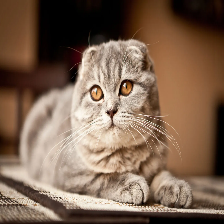

In [89]:
orig_pil = Image.open("./results_fgsm_mask_background/original_image_crop.png")
orig_pil

In [90]:
orig_array = np.array(orig_pil)
orig_label, orig_prob, orig_preds = get_model_pred(orig_array)
orig_label, orig_prob

1/1 [==============================] - 0s 52ms/step


('Egyptian_cat', 0.26560003)

<a id='Modifying_Specific_Superpixels'></a>
## 5. `Modifying Specific Superpixels`

In [91]:
from skimage.segmentation import slic, mark_boundaries

In [101]:
input_image_post = postprocess(input_image[0])
segments = slic(input_image_post, n_segments=40, compactness=10, sigma=1)

## display superpixels with boundaries

In [116]:
def display_superpixels(image, segments):
    fig, ax = plt.subplots(1,1, figsize=(4,4), sharex=True, sharey=True)
    ax.imshow(mark_boundaries(image, segments))
    ax.axis('off')
    plt.tight_layout()
    plt.show()

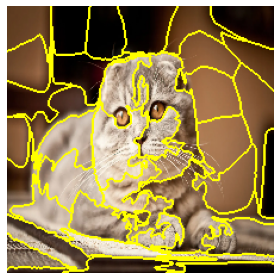

In [117]:
display_superpixels(input_image_post.numpy().astype(np.uint8), segments)

## Display annotated superpixels and boundaries

In [122]:
# Function to display the image with superpixel boundaries and annotations
def display_superpixels_annotated(image, segments):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True)

    for segment_id in range(len(segments)):
        mask = segments == segment_id
        mask = tf.cast(mask, tf.float32)

        ax.imshow(mark_boundaries(image, segments))

        if mask is not None:
            for idx, label in enumerate(np.unique(mask)):
                if label != 0:  # Ignore the background label
                    superpixel_mask = (mask == label)
                    if np.any(superpixel_mask):
                        y, x = np.where(superpixel_mask)
                        ax.text(x.mean(), y.mean(), str(label+segment_id-1), color='red', fontsize=12, weight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

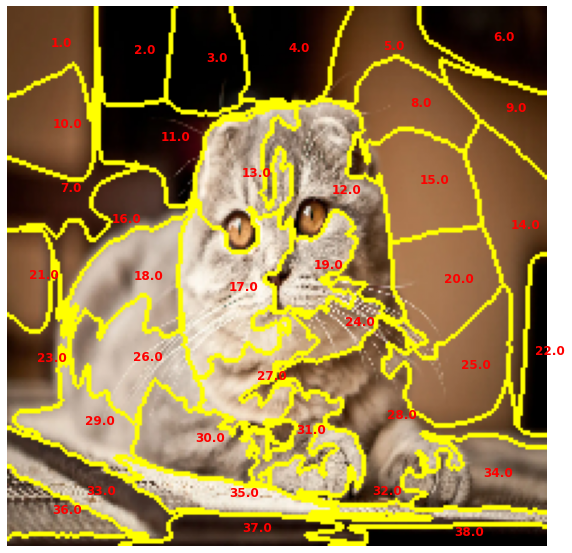

In [123]:
display_superpixels_annotated(input_image_postprocessed.numpy().astype(np.uint8), segments)

### Lets modify superpixel with index 17

In [175]:
def fgsm_attack(image, learning_rate, gradient):
    signed_grad = tf.sign(gradient)
    x_adv = image + learning_rate * signed_grad
    x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
    return x_adv
    
@tf.function
def get_gradients(image, model, target_class_index):
    with tf.GradientTape() as tape:
        tape.watch(image)
        pred = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(
            [target_class_index], pred
        )
    gradient = tape.gradient(loss, image)
    return gradient

In [176]:
selected_superpixel = 17
mask = segments == selected_superpixel
mask.shape

(224, 224)

In [177]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [179]:
# expanded_mask = np.expand_dims(mask, axis=-1)
# expanded_mask.shape

In [180]:
# # Now you can broadcast the mask to the shape of the image array
# broadcasted_mask = np.broadcast_to(expanded_mask, x_adv.shape)  # Shape will be (224, 224, 3)
# broadcasted_mask.shape

In [181]:
# mask = broadcasted_mask

In [182]:
# x_adv = tf.identity(input_image).numpy()
# x_adv[mask]

In [183]:
# # Apply the mask to the image array
# x_adv = x_adv[mask].reshape(x_adv.shape)  # This will keep the original shape

## Run FGSM on than superpixel

In [192]:
num_iter = 30
target_class_index = 254
learning_rate = 0.01

x_adv = tf.identity(input_image).numpy()

for iter in range(num_iter):
    gradients = get_gradients(input_image, base_model, target_class_index)
    
    #TODO: SOmething is wrong here, why it works when i copy it
    x_adv = tf.identity(x_adv).numpy()
    x_adv[0][mask] = fgsm_attack(x_adv[0][mask], learning_rate, gradients[0][mask])
    x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)
    
    x_adv_post = postprocess(x_adv[0])
    
    preds = base_model.predict(x_adv)
    decoded_predictions = decode_predictions(preds, top=3)[0]
    print(f"Iter {iter + 1} - Pred = {decoded_predictions}")

1/1 [==============================] - 0s 69ms/step
Iter 1 - Pred = [('n02124075', 'Egyptian_cat', 0.3175994), ('n02123159', 'tiger_cat', 0.1906267), ('n02123045', 'tabby', 0.14980823)]
1/1 [==============================] - 0s 60ms/step
Iter 2 - Pred = [('n02124075', 'Egyptian_cat', 0.33038992), ('n02123159', 'tiger_cat', 0.21713485), ('n02123045', 'tabby', 0.13535215)]
1/1 [==============================] - 0s 65ms/step
Iter 3 - Pred = [('n02124075', 'Egyptian_cat', 0.3550396), ('n02123159', 'tiger_cat', 0.2228543), ('n02123045', 'tabby', 0.122430325)]
1/1 [==============================] - 0s 77ms/step
Iter 4 - Pred = [('n02124075', 'Egyptian_cat', 0.3710801), ('n02123159', 'tiger_cat', 0.23480421), ('n02123045', 'tabby', 0.113723144)]
1/1 [==============================] - 0s 44ms/step
Iter 5 - Pred = [('n02124075', 'Egyptian_cat', 0.36591434), ('n02123159', 'tiger_cat', 0.25238556), ('n02123045', 'tabby', 0.113813825)]
1/1 [==============================] - 0s 58ms/step
Iter 6 - P

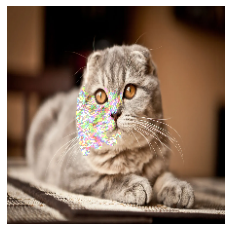

In [193]:
x_adv_post = postprocess(x_adv[0]).numpy()
plt.imshow(x_adv_post.astype(np.uint8))
plt.axis('off')
plt.show()

In [194]:
predictions = base_model.predict(x_adv)
decoded_pred = decode_predictions(predictions, top=3)[0]
decoded_pred

1/1 [==============================] - 0s 47ms/step


[('n02123159', 'tiger_cat', 0.33278745),
 ('n02123045', 'tabby', 0.23239043),
 ('n02124075', 'Egyptian_cat', 0.22682892)]

<a id='Next_Steps'></a>

# Next steps
- Experiment more with modifying either only the object (foreground) or only the background of the image
- Experiment more with superpixel modification
- NES attack
- More attacks

## Dockerize & Serve 
- Introduce `logging` module
- Add `typing` for each function
- `Dockerize` implementation
    - create Dockerfile and run inside a container to ensure same packages
    - serve the methods